# Importing relevant libraries

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
# Loading holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

import itertools
from pprint import pprint
from scipy.interpolate import interp1d
import scipy as sp

2023-03-15 12:06:39.216190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 12:06:39.340675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/python3/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-15 12:06:39.340700: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 12:06:39.970030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dl

In [169]:
print(tf.__version__)

2.11.0


In [4]:
import itertools
from pprint import pprint
from scipy.interpolate import interp1d
import scipy as sp

## Using Mediapipe to process Image

In [5]:
# Loading holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [6]:
def process_image(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

## Drawing landmarks 

In [7]:
def visualize_landmarks(image, results):
    # Face can be added for visualization purposes later on if needed. 
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 

## Setup for Training and Testing data

### Setup for Landmark / Keypoint extraction

In [8]:
def extract_keypoints(results):        
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, left_hand, right_hand])

### Defining our used Subset of the dataset

In [9]:
words =  np.array(['hvad', 'ja', 'soed'])

label_map = {label:num for num, label in enumerate(words)}

### Collecting Landmarks from video subset of dataset 

In [32]:
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:
    # Looping through subset of words we choose to work with 
    for word in words:
        dir_path = "tegn_subset/" + str(word) + "/"
        # Loop through videos
        for video in os.listdir(dir_path):
            if video.endswith('.mp4'):
                # Importing videos and extracting frame amount
                vid_file = cv2.VideoCapture(dir_path + str(video))
                frame_amount = int(vid_file.get(cv2.CAP_PROP_FRAME_COUNT))
          
                # Loop through video length aka sequence length
                for frame_nr in range(frame_amount):
                    ret, frame = vid_file.read()
                    image, results = process_image(frame, holistic_model)
                    # Used for visualization
                    #visualize_landmarks(image, results)

                    # Showing processed video with added landmarks (no specific purpsoe)
                    #cv2.imshow('OpenCV Feed', image)
                    
                    # Exporting Keypoints
                    keypoints = extract_keypoints(results)

                    # Finds current directory when all videos are in order called "word" + word number
                    current_directory = os.path.join("tegn_subset", str(word) + "_data", str(video.split(".")[0]))

                    # Creates above directory if it doesn't exist
                    if not (os.path.exists(current_directory)):
                        os.makedirs(current_directory)

                    np.save(os.path.join(current_directory, word) + str(frame_nr), keypoints)

                    # Being able to quit video if necessary
                    #if cv2.waitKey(10) & 0xFF==ord('q'):
                     # break
            else:
                continue
                 
    vid_file.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

KeyboardInterrupt: 

## Importing saved data and setting up Train and Test data arrays

In [112]:
# Keypoint_list_of_arrays is a python list containing "video amount" of NP arrays.
# Each array inside the list has size  
keypoint_list_of_arrays = []
labels = []
vid_frames = []
for word in words:
    dir_path = "tegn_subset/" + str(word) + "_data" + "/"
    for vid_folder in next(os.walk(dir_path))[1]:
        # Finds number of .npy files in current vid_folder
        frame_len = len([entry for entry in os.listdir(dir_path + str(vid_folder)) 
                        if entry.endswith('.npy') and os.path.isfile(os.path.join(dir_path + str(vid_folder), entry))])
        vid_frames.append(frame_len)
        tmp = []
        for frame_num in range(frame_len):
            imported_data = np.load(os.path.join(dir_path, vid_folder, word) + str(frame_num) + ".npy")
            tmp.append(imported_data)

        tmp = np.array(tmp)
        #print(tmp.shape)

        keypoint_list_of_arrays.append(tmp)
        labels.append(label_map[word])

max(vid_frames)


142

# Interpolating Keypoints

Extracting specific coordinates for right hand, left hand and pose from previously appended data.

Meaning our first $33*4$ out of 258 values are for pose, the next $21*3$ are for left_hand and the last $21*3$ are for right_hand.
We now want to seperate all coordinates and visibility values such that it is easy for us to access all specific coordinates 
for a single keypoint for all frames. 

We will then proceed to interpolate values for all coordinates 

In [113]:
# As input array HAS to be of size (frame_amount, 258)
def split_array(array_to_split):
    # Splits total array into pose values and hand values 
    posearr = array_to_split[:, 0:132]
    handarr = array_to_split[:, 132::]

    # Splititng handarr to seperate left hand from right hand values
    splithandarr = np.split(handarr, 2, axis=1)
    rhcoords = splithandarr[0]
    lhcoords = splithandarr[1]

    # Extracting specific coordinates for both the left and right hand
    rhxcoords = rhcoords[:, 0::3]
    lhxcoords = lhcoords[:, 0::3]

    rhycoords = rhcoords[:, 1::3]
    lhycoords = lhcoords[:, 1::3]

    rhzcoords = rhcoords[:, 2::3]
    lhzcoords = lhcoords[:, 2::3]

    # Splitting up coordinates and visibility values for pose
    pxcoords = posearr[:, 0::4]
    pycoords = posearr[:, 1::4]
    pzcoords = posearr[:, 2::4]
    pvis = posearr[:, 3::4]

    return pxcoords, pycoords, pzcoords, pvis, rhxcoords, rhycoords, rhzcoords, lhxcoords, lhycoords, lhzcoords

# With this splitting it seems that every row (out of 48 total) now contains all x coordinates for one frame for BOTH hands
# This means that to get all sequential x coordinates for one specific point we can take each column. 
# So column handxcoord[:, 0] is 

t = split_array(keypoint_list_of_arrays[0])


### Filtering for removal of outliars



In [114]:
from scipy.signal import butter,filtfilt
import plotly.graph_objects as go
fs = 20.0 # sample rate, Hz
cutoff = 2 # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
order = 2 # sin wave can be approx represented as quadratic

# Taken from https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(t[5][:,0], cutoff, fs, order)

fig = go.Figure()
fig.add_trace(go.Scatter(
            y = t[5][:,0],
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
fig.add_trace(go.Scatter(
            y = y,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
fig.show()


### Interpolating new keypoint using all sequential data for a single keypoint coordinate through all frames

In [115]:
def interpolate_frames(keypoint_data, current_frames, max_frames):
    # Calculate x and y values to be able to plot it later, furthermore also used for interpolation
    x = range(0,current_frames)
    y = keypoint_data

    if (current_frames != max_frames):
        new_x = np.linspace(0, current_frames-1, max_frames, endpoint=False)
        new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)
    else:
        return y
    # Plot the results

    #plt.figure()
    #plt.subplot(2,1,1)
    #plt.plot(x, y, 'bo-')
    #plt.title('Using 1D Cubic Spline Interpolation')

    #plt.subplot(2,1,2)
    #plt.plot(new_x, new_y, 'ro-')

    #plt.show()
    
    # Returning 3 values. keypoint_data are the input keypoint values. new_x are the x-coordinates for 
    # where we extract our new keypoint values from the curve.
    # new_y is our interpolated keypoint array. With size max_frames.
    return new_y


In [116]:
# This takes t[5] as input which is our rhxcoords array outputtet as a test earlier 
test = interpolate_frames((t[5])[:,0],  t[5].shape[0], max(vid_frames))

In [117]:
#test2 = interpolate_frames(x,  t[5].shape[0], max(vid_frames))


In [118]:
# This takes t[5] as input which is our rhxcoords array outputtet as a test earlier 
#test = interpolate_frames((t[0])[:,0],  t[0].shape[0], max(vid_frames))

In [119]:
def full_data_interpolation(data_array_list):
    interpolated_list = []
    for i in range(len(data_array_list)):
        split_data = split_array(data_array_list[i])
        tmp = []
        for coords in range(len(split_data)):
            coord_array = split_data[coords]
            for col in range(coord_array.shape[1]):
                normalized_data = preprocessing.normalize(coord_array[:, col].reshape(-1,1), axis=0).ravel()
                filtered_data = butter_lowpass_filter(normalized_data, cutoff, fs, order)
                interpolated_data = interpolate_frames(filtered_data,  filtered_data.shape[0], max(vid_frames))
                tmp.append(interpolated_data)

        interpolated_list.append((np.array(tmp)).T)
    return np.array(interpolated_list)

interpolated_list = full_data_interpolation(keypoint_list_of_arrays)
interpolated_list.shape

(62, 142, 258)

### Creating Training and Testing set

In [120]:
X = np.array(interpolated_list)
y = to_categorical(labels).astype(int)

print(X.shape)
print(y.shape)


(62, 142, 258)
(62, 3)


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 18, stratify=y)

# LSTM Neural Network Implementation

### Saving NN Logs

In [122]:
tracing_logs = TensorBoard(os.path.join('Logs'))

### NN Implementation

In [123]:
'''optimizer = tf.keras.optimizers.Adamax(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999)
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(142,258)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(words.shape[0], activation='softmax'))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
'''

"optimizer = tf.keras.optimizers.Adamax(\n    learning_rate=0.001,\n    beta_1=0.9,\n    beta_2=0.999)\nmodel = Sequential()\nmodel.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(142,258)))\nmodel.add(LSTM(64, return_sequences=True, activation='relu'))\nmodel.add(LSTM(32, return_sequences=False, activation='relu'))\nmodel.add(Flatten())\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dense(16, activation='relu'))\nmodel.add(Dense(words.shape[0], activation='softmax'))\n\nmodel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n"

In [124]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(142,258)))
model.add(Flatten())
model.add(Dense(words.shape[0], activation='softmax'))
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [166]:
model.fit(X_train, y_train, epochs=100, callbacks=[tracing_logs])

Epoch 1/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0063 - categorical_accuracy: 1.0000
Epoch 2/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0064 - categorical_accuracy: 1.0000
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0065 - categorical_accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0065 - categorical_accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0064 - categorical_accuracy: 1.0000
Epoch 6/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0063 - categorical_accuracy: 1.0000
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0059 - categorical_accuracy: 1.0000
Epoch 8/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0057 - categorical_accuracy: 1.0000
Epoch 9/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0053 - categorical_accuracy: 1.0000
Epoch 10/1

In [126]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score



In [127]:
yhat = model.predict(X_test)


1/1 [==============================] - 0s 177ms/step


In [128]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [129]:

multilabel_confusion_matrix(ytrue, yhat)

array([[[12,  1],
        [ 0,  5]],

       [[12,  0],
        [ 1,  5]],

       [[11,  0],
        [ 0,  7]]])

In [130]:
accuracy_score(ytrue, yhat)

0.9444444444444444

In [131]:
from tqdm.keras import TqdmCallback

In [155]:
vid_path = 'test1.mp4'

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:
    vid_file = cv2.VideoCapture(vid_path)
    num_frames = int(vid_file.get(cv2.CAP_PROP_FRAME_COUNT))
    tmp = []
    # Loop through video length aka sequence length
    for frame in range(num_frames):
        ret, frame = vid_file.read()
        image, results = process_image(frame, holistic_model)
        
        keypoints = extract_keypoints(results)
        tmp.append(keypoints)
    
    input_testing = [np.asarray(tmp)]

    testing_data = full_data_interpolation(input_testing)
    print(testing_data.shape)
       
    vid_file.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)


(1, 142, 258)


In [156]:
res = model.predict(testing_data)
res

1/1 [==============================] - 0s 60ms/step


array([[3.3511213e-08, 9.9999809e-01, 1.9433760e-06]], dtype=float32)

In [157]:
words[np.argmax(res)]

'ja'

In [165]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 142, 16)           17600     
                                                                 
 flatten_7 (Flatten)         (None, 2272)              0         
                                                                 
 dense_7 (Dense)             (None, 3)                 6819      
                                                                 
Total params: 24,419
Trainable params: 24,419
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.save('gfgModel.h5')

In [167]:
model.save('action.h5')

Train: 0.984


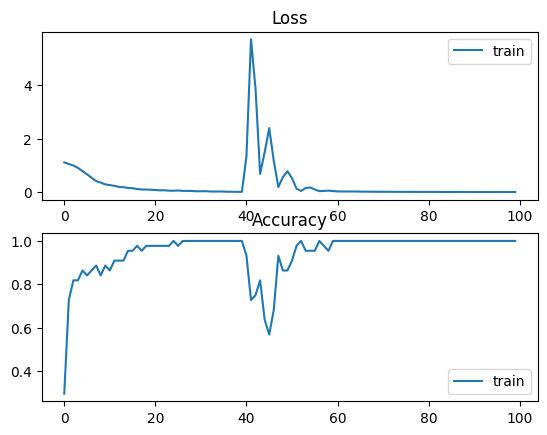

In [158]:
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
print('Train: %.3f' % (train_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.legend()
plt.show()

In [159]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


KeyError: 'val_accuracy'